# Setup

If you haven't already please install mallet. As that will be required to run the following notebook. There is also a back up alterative lda model we will allow usage of (LDA Multicore). This can be used by passing a different argument.

### Pre Processing

In [1]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

We have filtered all news headlines from Reuters from 2014 to 2016 by checking for the occurence of the word 'oil'. We then aggregate file corpus into a line corpus, provided as a CSV file ('oil_news.csv'). We have functions in our Python script that will read this in and perform the following pre-processing steps:

- Remove Stop Words (NLTK) 
- Lower Case (Gensim) 
- Remove Punctuation (Gensim) 
- Remove Numbers (Gensim) 
- Stemmed/Lemmatized (NLTK) 

After this we use the bag of words approach and build up a corpus of pre-processed documents. This is all done by invoking the get_text_data() method.

In [34]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [2]:
from CTADaily import get_text_data
text_df, dictionary, corpus = get_text_data('WTI-NEWS.csv', 'Headline')

C:\Users\Yash\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
text_df.head(2)

,Date,Headline
0,2014-01-02,"[brazil, oleo, gas, say, honor, oil, field, debt]"
1,2014-01-02,"[cabot, oil, gas, corpor, declar, dividend]"


### Building The Model

In [4]:
from CTADaily import build_lda_model
lda_model = build_lda_model('Mallet', corpus, dictionary, num_topics=10)

If you were unable to install Mallet, there is an alternative model type you can use which is the LDA Multicore method from gensim. This can be simply passed into build_lda_model as follows:

In [5]:
#lda_model = build_lda_model('Multicore', corpus, dictionary, num_topics=10)

#### Optimizing Model by Coherence

In [6]:
from gensim.models.coherencemodel import CoherenceModel
from CTADaily import get_tokens 

tokens = get_tokens(text_df, 'Headline')

cm = CoherenceModel(model=lda_model, corpus=corpus, texts=tokens, coherence='c_v')
coherence = cm.get_coherence()
print(coherence)

0.37959492487006535


We see quite a low coherence value of 0.38 for 20 topics. Let's try to optimise this.

In [27]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(tokens, corpus, dictionary, range(1, 10, 1))

Building Model with 1 #Topics
Coherence 0.1532535840128281
Building Model with 2 #Topics
Coherence 0.25021754159673515
Building Model with 3 #Topics
Coherence 0.3520933012191949
Building Model with 4 #Topics
Coherence 0.44989719375537823
Building Model with 5 #Topics
Coherence 0.43226272533534127
Building Model with 6 #Topics
Coherence 0.3983602067041176
Building Model with 7 #Topics
Coherence 0.3901022374425521
Building Model with 8 #Topics
Coherence 0.3732385538372965
Building Model with 9 #Topics
Coherence 0.3995953241000658


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

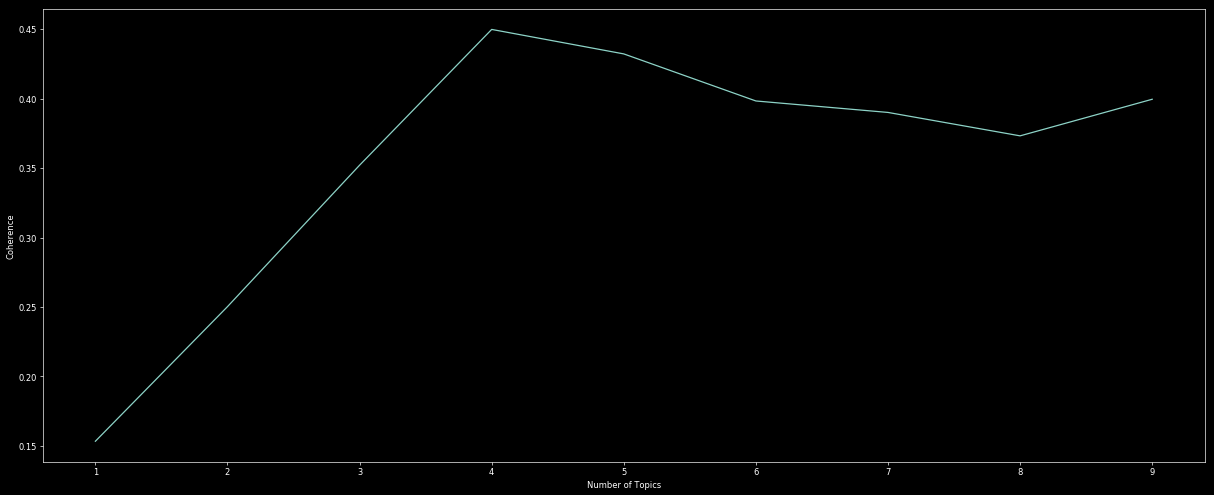

In [29]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(1, 10, 1), scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

#### Analysis

Generally, we see that the coherence is quite low. There may multiple reasons for this. We require more training data, so that the topics could overlap and thus the coherence would become better with a lower number of topics. We may have also considered word n grams to further improve our LDA model coherence.

### Bigram and Trigram

In [105]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser 


words = pandas.read_csv('WTI-NEWS.csv')
bigram_phraser = Phraser(Phrases(tokens, min_count=1, threshold=2))

In [108]:
print(bigram_phraser[tokens[2]])

['global_market', 'stock', 'slide', 'stellar', 'oil_price', 'tumbl']


#### Rebuild Corpus

In [40]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [71]:
import gensim.corpora as corpora
bigram = Phrases([" ".join(words) for words in tokens], min_count=5, threshold=100)
bigram
bigram_mod = Phraser(bigram)

bigrams = make_bigrams([[doc] for doc in [" ".join(words) for words in tokens]])
dictionary = corpora.Dictionary(bigrams)
corpus = [dictionary.doc2bow(text) for text in bigrams]

In [ ]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(bigrams, corpus, dictionary, range(1, 10, 1))

### Regression Model

We will now be able to get the topic distribution for each document. We want to use these probabilities as features for our regression, combined with the date the headline was published by Reuters. We will need to unpack the tuples, to remove the topic number and only give us the probability. We will do this for all columns before merging date

In [13]:
import pandas
lda_model = models[-1]
topic_dist_df = pandas.DataFrame(lda_model[corpus])

for column in topic_dist_df.columns:
    topic_dist_df[column] = topic_dist_df[column].apply(lambda x : x[1])

In [14]:
topic_dist_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0.026777,0.009234,0.009234,0.009234,0.013132,0.009234,0.009234,0.009234,0.009234,0.009234,...,0.009234,0.015082,0.009234,0.009234,0.011183,0.009234,0.009234,0.009234,0.009234,0.009234
1,0.009398,0.009398,0.009398,0.009398,0.009398,0.009398,0.009398,0.011383,0.009398,0.011383,...,0.013367,0.009398,0.009398,0.009398,0.009398,0.011383,0.009398,0.009398,0.009398,0.009398


In [16]:
dates = pandas.read_csv('WTI-NEWS.csv')['Date']
topic_dist_df = pandas.concat([dates, topic_dist_df], axis=1, sort=False)

In [17]:
topic_dist_df.head(2)

,Date,0,1,2,3,4,5,6,7,8,...,85,86,87,88,89,90,91,92,93,94
0,2014-01-02,0.026777,0.009234,0.009234,0.009234,0.013132,0.009234,0.009234,0.009234,0.009234,...,0.009234,0.015082,0.009234,0.009234,0.011183,0.009234,0.009234,0.009234,0.009234,0.009234
1,2014-01-02,0.009398,0.009398,0.009398,0.009398,0.009398,0.009398,0.009398,0.011383,0.009398,...,0.013367,0.009398,0.009398,0.009398,0.009398,0.011383,0.009398,0.009398,0.009398,0.009398


Now we will merge the WTI Crude Oil Prices from our exported historical data. We have more dates in that dataset than the range of the dates from our headlines. Hence, we will perform an inner join between them on the matching column 'Date'. 

In [18]:
wti_prices = pandas.read_csv('DCOILWTICO.csv')
topic_prices = pandas.merge(topic_dist_df, wti_prices, on='Date')

##### topic_prices.head(2)

In [21]:
columns = ['Date'] + ['Topic {}'.format(i) for i in range(95)] + ['Price']
topic_prices.columns = columns

Let's save this to a file for easier analysis.

In [24]:
topic_prices.to_csv('WTI-LDA-TOPIC.csv', index=False)